In [1]:
from sympy import Matrix, symbols, sin, cos, trigsimp, init_printing, I, \
    simplify, Eq, solve, expand, lambdify, diff, solveset, exp, factor


In [2]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial
init_printing()

In [3]:
%matplotlib inline

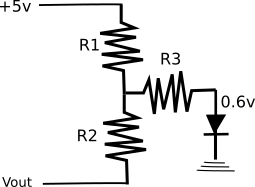

The object of this exercise is to maximise the change in current through i3 as a result in change in Voltage signal from Vout when Vout is in the millivolt range.  The ultimate goal is to replace the diode with an NPN transistor to amplify the current.  The 0.6V is an attempt to model the switch on voltage of that transistor.

In [4]:
r1, r2, r3, i1, i2, i3, vo, vbe, n, vd, vt, Is = symbols("r_1 r_2 r_3 i_1 i_2 i_3 Vout V_{BE} n V_D V_T I_S")

$ 5 - V_{out} = R_1 * i_1 + R_2 * i_2 $ \

$ 5 - V_{BE} = 4.4 = R_1 * i_1 + R_3 * i_3 = R_1 * i_1 + R_3 * (i_1 - i_2) = (R_1 +R_3) * i_1 - R_3 * i_2 $ 

Because i1 is entering the junction and i2 is leaving the junction then because of conservation of charge the current going through R3 must be i1 - i2

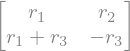

In [5]:
m = Matrix([[r1, r2], [r1+r3, -r3]]); m

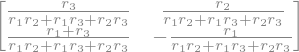

In [6]:
minv = m**-1; minv

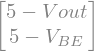

In [7]:
b = Matrix([5-vo, 5-vbe]); b

We now try to calculate the currents i1 and i2 by multiplying the matrix inverse by vector b

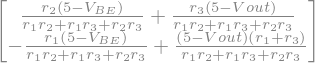

In [8]:
b2 = minv*b; b2

The current through R3 then $ i_3 = i_1 - i_2 $ is the current through R3 due to the conservation of charge law.

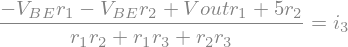

In [9]:
expr1 = Eq(simplify(b2[0]-b2[1]), i3); expr1

Now we just plug in some values to make sure the calculations look right

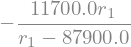

In [10]:
e1 = solve(expr1.subs(((vbe, 0.6), (vo,0.020), (i3,0.00005), (r3,100))), r2)[0]; e1

Now we want to produce some graphs to see what resistance values are likely to make this work if we are thinking we want a $V_{out}$ of 20mV should produce a current of 50$\mu$A.

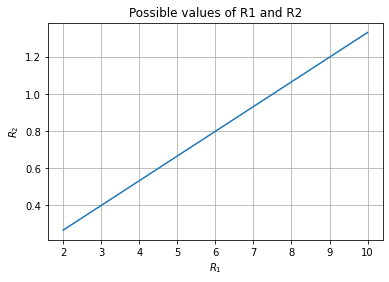

In [11]:
fig, ax = plt.subplots()
x = np.linspace(2, 10, 1000)
f1 = lambdify(r1, e1, "numpy")
ax.set_ylabel("$ R_2 $")
ax.set_xlabel("$ R_1 $")
ax.set_title("Possible values of R1 and R2")
ax.plot(x, f1(x))
ax.grid()


That looks reasonable so now we try for different values of R3 and see if R3 is really necessary.

In [12]:
from matplotlib import ticker
def plotR2s(milliVolts, microAmps, lin=None, vbeval=0.6, r3codes=[(1000,'b'), (500, 'b:'), (200, 'b--'), (100, 'b-.')] ):
    if lin:
        x = np.linspace(*lin)
    else:
        x = np.linspace(0, 10000, 1000)
    plt.figure(figsize=(7,7))
    lines = []
    legends = []
    for r, c in r3codes:
        expr2 = solve(expr1.subs(((vo, milliVolts/1000),(r3,r),(i3, microAmps/1000000), (vbe, vbeval))), r2)
        f2 = lambdify(r1, expr2, "numpy")
        line2d, = plt.plot(x, f2(x)[0], c)
        currax = plt.gca()
        currax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:.1f} K".format(x/1000)))
        currax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:.1f} K".format(x/1000)))
        lines.append(line2d)
        legends.append("R3 = {:1.2f} K".format((r/1000)))

    plt.grid()

    plt.xlabel("R1")
    plt.ylabel("R2")
    plt.legend(lines, legends)
    plt.title("R1 vs R2 where $V_{{out}} = {} mV $ and $ i_3 $ = {} $ \mu $ A".format(milliVolts, microAmps,))
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

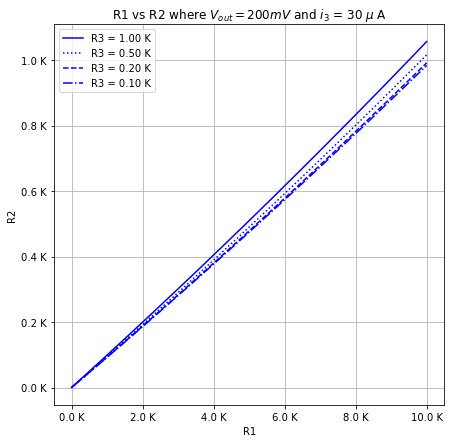

In [13]:
plotR2s(200, 30, (0, 10000, 1000))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

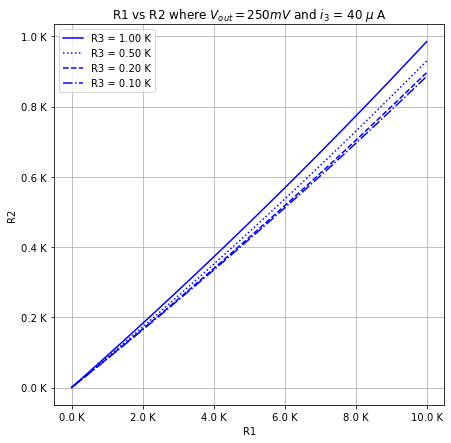

In [14]:
plotR2s(250, 40, (0,10000, 1000))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

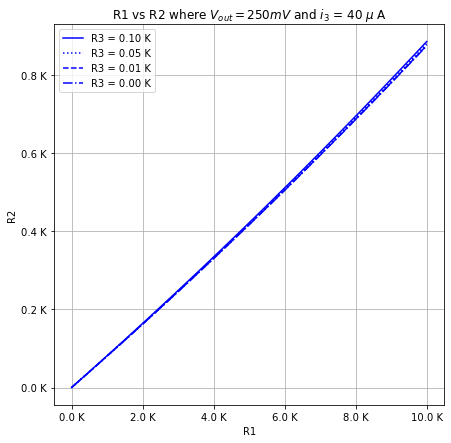

In [15]:
plotR2s(250, 40, (0,10000, 1000), r3codes=[(100,'b'), (50, 'b:'), (10, 'b--'), (0, 'b-.')] )

So a good match looks like R1 = 8K, R2 = 1K and R3 = 100 ohms (or less)

We've currently been modelling this as a linear equation but let's see what happens if we treat the diode as non-linear.

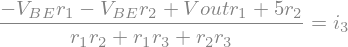

In [16]:
expr1

Apprently n = 1 for germanium and n = 2 for silicon and $ V_T $ is about 27mV at room temperature.  (For me it seems more like 16mV.)

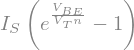

In [17]:
expr2 = Is * (exp(vbe/(n*vt))-1); expr2

Now invert this equation so that we can solve for $V_{BE}$ and make the diode current the subject of the equation.

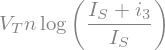

In [18]:
expr3 = solve(Eq(expr2,i3), vbe)[0]; expr3

Now plug in some realistic values for $n \cdot V_{T}$ and $I_S$

In [19]:
e2 = expr2.subs(((n*vt,0.0321822385401455), (Is, 1.6e-12))); e2

Now plot the diodes V-I characteristic

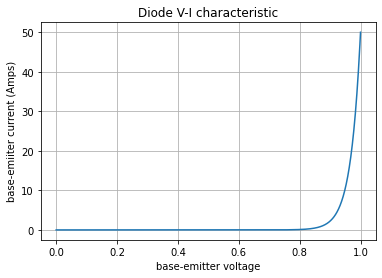

In [20]:
fig, ax = plt.subplots()
x = np.linspace(0, 1, 1000)
f1 = lambdify(vbe, e2, "numpy")
ax.set_ylabel("base-emiiter current (Amps)")
ax.set_xlabel("base-emitter voltage")
ax.set_title ('Diode V-I characteristic')
ax.plot(x, f1(x))
ax.grid()


Now we want to add this result into our previous linear equation for the entire circuit.  (Of course now it will be non-linear).

In [21]:
vtval = 0.0321822385401455/2; vtval

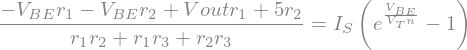

In [22]:
expr4 = Eq(expr1.args[0], expr2); expr4

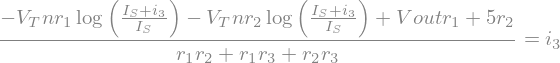

In [23]:
expr5 = expr1.subs(vbe, expr3); expr5

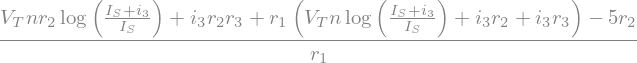

In [24]:
expr6 = solve(expr5, vo)[0]; expr6

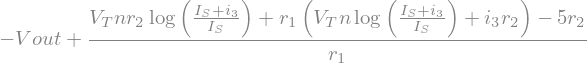

In [25]:
expr7 = simplify(expr6.subs(r3,0))-vo; expr7

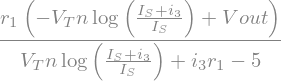

In [26]:
e7 = solve(expr7, r2)[0]; e7

In [27]:
e8 = e7.subs(((Is, 1.6e-12),(n,2),(vt,vtval), (i3, 0.000050),(vo,0.020))); e8

In [28]:
f1 = lambdify(r1, e8, "numpy")

In [29]:
e9 = e7.subs(((Is, 1.6e-12),(n,2),(vt,vtval), (i3, 0.000055),(vo,0.025))); e9

In [30]:
f2 = lambdify(r1, e9, "numpy")

In [31]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 1000)
ax.set_ylabel("$ R_{2} $")
ax.set_xlabel("$ R_1 $")
ax.set_title("R1 vs R2")
ax.plot(x, f1(x), label="Vout = 20mV, i3 = 50 $ \mu $A")
ax.plot(x, f2(x), label="Vout = 25mV, i3 = 55 $\mu$A")
ax.grid()
ax.legend()

So R1 = 8K and R2 = 1K look like a good starting candidate.